# Projeto 1 - Ciência dos Dados

Nome: Antonio Anderson de Araújo Julião

Nome: João Pedro Sardou de Oliveira

Nome: Antonio Carlos Gomes dos Santos Filho

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [36]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [37]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\anton\Antonio\Insper\2° Semestre\CDados\Projeto 1\classificador-de-mensagem-1


Carregando a base de dados com os tweets classificados manualmente:

In [38]:
train = pd.read_csv('dados_treino_TRIO_joaopso2.csv')
train.head(5)

,sentence,target
0,While not specifically designed for file trans...,AI
1,This matrix is closely linked to a Role-Based ...,HG
2,Although Java is a general-purpose programming...,HG
3,"In the following decades, hacking grew in popu...",AI
4,"net (network service providers, and so on).",HG


In [39]:
test = pd.read_csv('dados_teste_TRIO_joaopso2.csv')
test.head(5)

,sentence,target
0,Design patterns provide a common language and ...,AI
1,The loop is the programming language struc...,HG
2,"In the following decades, researchers continue...",AI
3,This is continued until the partition size is ...,HG
4,Polymorphism is a concept in object-oriented p...,AI


In [40]:
train['target'].value_counts()

AI    793
HG    677
Name: target, dtype: int64

In [41]:
test['target'].value_counts()

AI    334
HG    296
Name: target, dtype: int64

___
## Classificador automático


O modelo desenvolvido nesse projeto estuda uma base de dados que contém textos gerados por Humanos e por Inteligência Artificial. Dessa maneira, as classificações desses textos tem como base dois grupos:

* AI: Texto gerado por Inteligência Artificial.
* HG: Texto gerado por Humano.

## Tratamento de Dados:

Antes de iniciarmos as classificações, é fundamental uma preparação dos dados visando um melhor rendimento nas próximas etapas.

### Limpeza de Dados:

In [42]:
# https://docs.python.org/3/library/re.html#
import re 
import unidecode

def cleanup(text):
    
    #Retirar pontuações do texto
    pontuacao = '[´"!-.:1234567890?;$/'']' 
    pattern = re.compile(pontuacao)
    texto_limpo = re.sub(pattern, '', text)
    
    #Retirar acentos do texto
    texto_limpo = unidecode.unidecode(texto_limpo)
    return texto_limpo  

In [43]:
def tokenize(texto):
    
    # Converter letras maiúsculas para minúsculas
    texto = texto.lower()
    palavras = texto.split()

    # Lista para armazenar os bigramas
    bigramas = []

    # Loop para criar bigramas por meio de uma lista de palavras
    for i in range(len(palavras) - 1):
        bigrama = palavras[i] + " " + palavras[i + 1]
        bigramas.append(bigrama)

    return bigramas

In [80]:
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('English')
stop_words.append('')
stop_words = list(stop_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Remover palavras irrelevantes

def stop_word(lista_texto):   
    new_list = list()
    for palavra in lista_texto:
        if palavra not in stop_words:
            new_list.append(palavra)

    return new_list

In [46]:
# Reduzir as palavras à sua forma raiz ou base 
from nltk.stem.snowball import SnowballStemmer

def stemming(lista_texto):
    stemmer = SnowballStemmer('portuguese')
    new_list = list()
    for palavra in lista_texto:
        new_list.append(stemmer.stem(palavra))
    
    return new_list

In [47]:
#Converte o DataFrame em string

def to_text(data):
    texto = ''
    for frase in data.sentence:
        texto += frase + " " 
    return texto

In [48]:
# Executa as funções de limpeza no DataFrame

def run(texto):
    texto = to_text(texto)
    texto = cleanup(texto)
    texto = tokenize(texto)
    texto = stop_word(texto)
    texto = stemming(texto)
    series_texto = pd.Series(texto, dtype='object')
    return series_texto

In [49]:
# Executa todas as funções de limpeza para uma string

def run2(texto):
    texto = cleanup(texto)
    texto = tokenize(texto)
    texto = stop_word(texto)
    texto = stemming(texto)
    series_texto = pd.Series(texto, dtype='object')
    return series_texto

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

#### 1. Classificação dos grupos

* O modelo necessita ser treinado por meio de um conjunto de dados rotulados. A nossa situação é composta de um conjunto de dados que consiste em textos gerados por Humanos ou por Inteligência Artificiais, as quais são agrupadas nas seguintes categorias: HG e AI

In [50]:
HG = train.loc[train.target == 'HG',:]
AI = train.loc[train.target == 'AI',:]

In [51]:
# Frequências Relativas:

tabela_relativa_HG = run(HG).value_counts(True)
tabela_relativa_AI = run(AI).value_counts(True)

In [52]:
#Frequências Absolutas

tabela_absoluta_HG = run(HG).value_counts()
tabela_absoluta_AI = run(AI).value_counts()

In [53]:
#Frequências da Base de Treino

tabela_train = run(train)
tabela_train_relativa = tabela_train.value_counts(True)
tabela_train_absoluta = tabela_train.value_counts()

In [54]:
#Treino sem repetição de palavras

tabela_train_sem_repetir = set(tabela_train)

* Probabilidades a Priori (Prior Probability): Para cada grupo (HG e AI), calculamos a probabilidade a priori, ou seja, a probabilidade de um texto pertencer a cada um desses grupos. Isso é feito contando quantos textos existem em cada grupo e dividindo pelo total de textos.

$$P(HG) = \frac{Número De Palavras HG}{Número De Palavras Totais}$$


$$P(AI) = \frac{Número De Palavras AI}{Número De Palavras Totais}$$

In [55]:
P_HG = tabela_absoluta_HG.sum()/tabela_train_absoluta.sum()
P_AI = tabela_absoluta_AI.sum()/tabela_train_absoluta.sum()

* Probabilidades Condicionais (Likelihood): Para cada palavra (característica) no conjunto de dados, calculamos a probabilidade condicional de a palavra aparecer em um texto de cada grupo. Essas probabilidades condicionais são calculadas separadamente para cada grupo.

$$P(Palavra|HG) = \frac{P(HG|Palavra) P(Palavra)}{P(HG)}$$


$$P(Palavra|AI) = \frac{P(AI|Palavra) P(Palavra)}{P(AI)}$$

* Probabilidade a Posteriori (Posterior Probability): Usando o teorema de Bayes, combinamos as probabilidades a priori e as probabilidades condicionais para calcular a probabilidade a posteriori de um novo texto pertencer a cada um dos dois grupos.

Por exemplo, para um novo comentário, podemos calcular a probabilidade a posteriori de pertencer ao HG e ao AI.

In [56]:
def calcula_prob(frase ,tabela_absoluta, tabela_train_sem_repetir, prob, alpha=0.05):
    
    prob_condicional = 1
    for palavra in frase:
        if palavra in tabela_absoluta:    
            #Suavização de Laplace
            p = (tabela_absoluta[palavra] + alpha)/ (tabela_absoluta.sum() + len(tabela_train_sem_repetir) * alpha) 
            prob_condicional *= p * prob
            
        else:
            #Suavização de Laplace
            q =(0 + alpha)/ (tabela_absoluta.sum() + len(tabela_train_sem_repetir) * alpha)
            prob_condicional *= q * prob
            
    return prob_condicional

#### 2. Classificação de Novos Comentários:

Após o modelo ser treinado, ele pode ser usado para classificar novos textos em uma das duas categorias com base nas probabilidades calculadas.


* Classificação: Finalmente, classificamos um novo texto no grupo com a maior probabilidade a posteriori. O grupo com a probabilidade mais alta é considerado a categoria prevista para o comentário.

Por exemplo, se a probabilidade a posteriori mais alta for a do AI, o novo texto será classificado como pertencente ao AI, indicando que ele contém sentimentos relacionados a textos gerados por Inteligência Artificial.

In [57]:
def classificador_de_frases(data):
    
    resultado = []

    for frase in data.sentence:
        
        frase = run2(frase) # Aplica a função run2 que limpa a frase

        aux = []
        probFrase_dado_HG = 1 
        probFrase_dado_AI = 1
        
        #Calculamos a probabilidade posteriori de cada frase para cada target
        
        probFrase_dado_HG = calcula_prob(frase,tabela_absoluta_HG,tabela_train_sem_repetir,P_HG)
        probFrase_dado_AI = calcula_prob(frase,tabela_absoluta_AI,tabela_train_sem_repetir,P_AI) 
        
        #Verificamos o maior termo e adicionamos seu respectivo valor semântico na lista
        aux.append(probFrase_dado_HG)
        aux.append(probFrase_dado_AI)
        aux = sorted(aux, reverse=True)
        
        if aux[0] == probFrase_dado_HG:
            resultado.append("HG")
        else:
            resultado.append("AI")
            
        
    return resultado

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [58]:
lista_teste = classificador_de_frases(test)

In [59]:
test['Bot'] = lista_teste
verificacao = pd.crosstab(test.target, test.Bot, normalize = True, margins = True)
verificacao

Bot,AI,HG,All
target,,,
AI,0.471429,0.058730,0.530159
HG,0.225397,0.244444,0.469841
All,0.696825,0.303175,1.000000


In [60]:
# Verdadeiros Positivos

verdadeiro_positivo = (verificacao["AI"]["AI"]/verificacao["All"]["AI"])*100
verdadeiro_positivo

88.92215568862275

In [61]:
# Falsos Positivos

falso_positivo = (verificacao["AI"]["HG"]/verificacao["All"]["HG"])*100
falso_positivo

47.972972972972975

In [62]:
# Verdadeiros Negativos

verdadeiro_negativo = 100 - falso_positivo
verdadeiro_negativo

52.027027027027025

In [63]:
# Falsos Negativos

falso_negativo = 100 - verdadeiro_positivo
falso_negativo

11.077844311377248

In [64]:
#Acurácia

acuracia = ((verificacao["AI"]["AI"] + verificacao['HG']["HG"]))*100
acuracia

71.58730158730158

___
### Concluindo

#### O classificador apresenta um bom desempenho na identificação de mensagens que são realmente verdadeiras. No entanto, enquanto classificador, precisa aumentar sua performance na identificação de mensagens que são realmente negativas, visto que conseguiu identificar menos da metade dessas.

#### Esse classificador Naive-Bayes pode ser útil para diferentes contextos, entre eles a identificação prévia de emails, classificando-os como propostas de reunião, busca de informações específicas que é responsabilidade de um determinado setor e já direcioná-los para as pessoas mais adequadas para aquele assunto.

#### Em busca de aperfeiçoar o classificador é preciso entender onde se encontra a maioria dos seus erros. Isso está ocorrendo na classificação de mensagens de feitas por humanos, as quais o classificador está indicando como feitas por uma IA. Nesse sentido, é preciso identificar erros de escritas, ou o duplo espaçamento entre palavras que podem ocorrer em mensagens feitas por humanos.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [65]:
from sklearn.model_selection import train_test_split

In [70]:
acuracias = []

for i in range(100):
    bases_juntas = pd.concat([test, train])
    nova_treino, nova_teste = train_test_split(bases_juntas, test_size=0.3, train_size=0.7)
    
    
    HG = nova_treino.loc[nova_treino.target == 'HG',:]
    AI = nova_treino.loc[nova_treino.target == 'AI',:]

    # Frequências Relativas:

    tabela_relativa_HG = run(HG).value_counts(True)
    tabela_relativa_AI = run(AI).value_counts(True)

    #Frequências Absolutas

    tabela_absoluta_HG = run(HG).value_counts()
    tabela_absoluta_AI = run(AI).value_counts()

    #Frequências da Base de Treino

    tabela_train = run(nova_treino)
    tabela_train_relativa = tabela_train.value_counts(True)
    tabela_train_absoluta = tabela_train.value_counts()

    #Treino sem repetição de palavras

    tabela_train_sem_repetir = set(tabela_train)

    P_HG = tabela_absoluta_HG.sum()/tabela_train_absoluta.sum()
    P_AI = tabela_absoluta_AI.sum()/tabela_train_absoluta.sum()

    lista_teste = classificador_de_frases(test)

    test['Bot'] = lista_teste
    verificacao = pd.crosstab(test.target, test.Bot, normalize = True, margins = True)

    acuracia = ((verificacao["AI"]["AI"] + verificacao['HG']["HG"]))*100

    acuracias.append(acuracia)




    

    
    

    
        



In [71]:
print(acuracias)

[92.22222222222223, 92.85714285714286, 91.58730158730158, 92.85714285714286, 91.74603174603175, 91.42857142857143, 92.38095238095238, 92.6984126984127, 90.95238095238095, 89.2063492063492, 92.85714285714286, 92.22222222222223, 90.63492063492063, 91.58730158730158, 92.06349206349206, 90.7936507936508, 91.74603174603175, 91.42857142857143, 91.42857142857143, 89.84126984126983, 90.63492063492063, 91.5873015873016, 91.58730158730158, 89.84126984126983, 90.95238095238095, 91.42857142857143, 90.95238095238095, 91.74603174603175, 89.99999999999999, 91.11111111111111, 90.63492063492063, 92.06349206349206, 90.79365079365078, 90.3174603174603, 90.47619047619048, 92.85714285714286, 90.7936507936508, 90.47619047619048, 90.63492063492063, 91.58730158730158, 91.9047619047619, 90.00000000000001, 91.58730158730158, 92.22222222222221, 90.3174603174603, 90.47619047619047, 91.42857142857143, 90.47619047619047, 93.01587301587301, 91.11111111111111, 92.06349206349206, 90.7936507936508, 90.47619047619047, 8

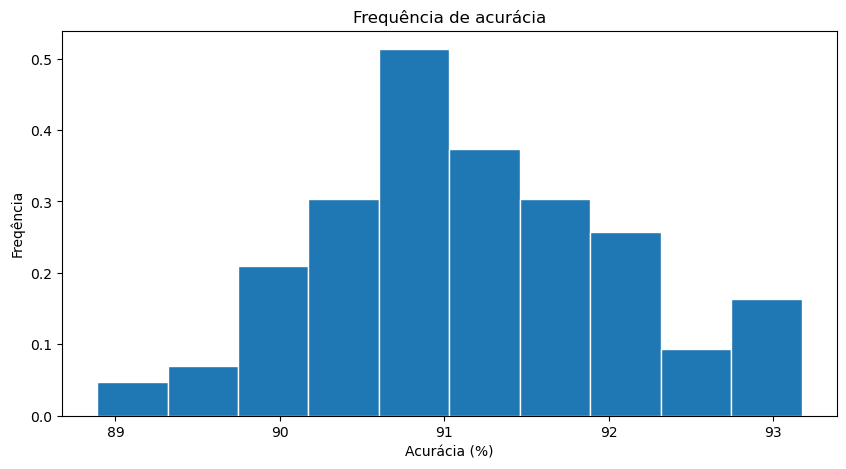

In [78]:
plt.figure(figsize=(10,5))

plt.hist(acuracias, edgecolor='white', density=True)
plt.title('Frequência de acurácia')
plt.xlabel('Acurácia (%)')
plt.ylabel('Freqência')
plt.show()

Foi possível perceber que construir um classificador com apenas uma divisão da base de dados em treino e teste não é possível ter uma clara certeza de sua verdadeira acurácia. Nesse sentido, repetir o processo com diferentes distribuições da base de dados entre treino e teste permite entender a verdadeira acurácia do classificador. Nesse caso, pode-se dizer que a acurácia desse classificador gira em torno de 91%.

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**